In [16]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import math
import random
from torch.utils.data import Dataset, DataLoader

In [4]:
import cv2

In [4]:
#import albumentations # Image augmentation
#import timm # Pretrained models

In [5]:
train_data = pd.read_csv(r'train.csv', sep =',')

In [6]:
train_data

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069
...,...,...,...,...,...
34245,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...,3776555725
34246,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,2736479533
34247,train_614977732,fff421b78fa7284284724baf249f522e.jpg,ad27f0d08c0fcbf0,KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...,4101248785
34248,train_3630949769,fff51b87916dbfb6d0f8faa01bee67b8.jpg,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...",1663538013


In [7]:
# Posting_id is a primary key
train_data['posting_id'].duplicated().sum()

0

In [8]:
# Titles can be the same
train_data['title'].duplicated().sum()

1133

In [9]:
#Images dataframe
image_f = train_data['image']
images = [r'train_images/' + image for image in image_f]
for i in range(10):
    images[i] = cv2.imread(images[i])
    images[i]= cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

In [10]:
image_f[0]

'0000a68812bc7e98c42888dfb1c07da0.jpg'

In [11]:
type(images[0])

numpy.ndarray

In [12]:
i_t = transforms.ToTensor()(images[0])

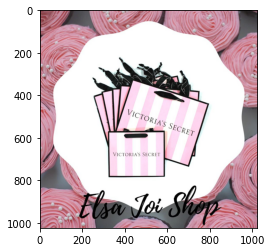

In [13]:
plt.imshow(images[0])

In [48]:
images_tensor = [transforms.ToTensor()(img) for img in images]

TypeError: pic should be PIL Image or ndarray. Got <class 'str'>

In [14]:
i_t = transforms.Resize((512,512))(i_t)
i_t = i_t.unsqueeze(dim=0)
i_t.size()

torch.Size([1, 3, 512, 512])

In [96]:
# Normalizing data
A = transforms.Resize((512,512))(images_tensor[0])
imA = transforms.ToPILImage()(A)

In [17]:
# Createing dataset
class ShopeeDataset(Dataset):
    def __init__(self, csv):
        self.csv = csv

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        title = row.title
        image = cv2.imread(row.filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image,torch.tensor(row.label_group)

In [18]:
#defining random model for benchmark
# We suppose model is normalized and is in (3,n,n) format
class RandNet(nn.Module):
    def __init__(self, n_classes, fc_dim = 512):
        super(RandNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.maxpool = nn.MaxPool2d(2, stride = 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.final_layer = nn.Linear(32*128*128, n_classes)
        
    def embedding(self, x):
        vector = nn.functional.relu((self.conv1(x)))
        vector = self.maxpool(vector)
        vector = nn.functional.relu((self.conv2(vector)))
        vector = self.maxpool(vector)
        return vector
    
    def forward(self,x):
        z = self.embedding(x)
        z = z.view(-1, 32*128*128)
        return self.final_layer(z)
        
    

In [19]:
rnet = RandNet(20)

In [ ]:
rnet(i_t)

In [43]:
images_tensor[0].shape

NameError: name 'images_tensor' is not defined

In [ ]:
class ShopeeNet(nn.Module):

    def __init__(self,
                 n_classes,
                 model_name='efficientnet_b0',
                 use_fc=False,
                 fc_dim=512,
                 dropout=0.0,
                 loss_module='softmax',
                 s=30.0,
                 margin=0.50,
                 ls_eps=0.0,
                 theta_zero=0.785,
                 pretrained=True):
        """
        :param n_classes:
        :param model_name: name of model from pretrainedmodels
            e.g. resnet50, resnext101_32x4d, pnasnet5large
        :param pooling: One of ('SPoC', 'MAC', 'RMAC', 'GeM', 'Rpool', 'Flatten', 'CompactBilinearPooling')
        :param loss_module: One of ('arcface', 'cosface', 'softmax')
        """
        super(ShopeeNet, self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        final_in_features = self.backbone.classifier.in_features
        
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        
        self.pooling =  nn.AdaptiveAvgPool2d(1)
            
        self.use_fc = use_fc
        if use_fc:
            self.dropout = nn.Dropout(p=dropout)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.loss_module = loss_module
        if loss_module == 'arcface':
            self.final = ArcMarginProduct(final_in_features, n_classes,
                                          s=s, m=margin, easy_margin=False, ls_eps=ls_eps)
        elif loss_module == 'cosface':
            self.final = AddMarginProduct(final_in_features, n_classes, s=s, m=margin)
        elif loss_module == 'adacos':
            self.final = AdaCos(final_in_features, n_classes, m=margin, theta_zero=theta_zero)
        else:
            self.final = nn.Linear(final_in_features, n_classes)

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x, label):
        feature = self.extract_feat(x)
        if self.loss_module in ('arcface', 'cosface', 'adacos'):
            logits = self.final(feature, label)
        else:
            logits = self.final(feature)
        return logits

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)

        return x